In [13]:
## Packages
# data wrangling
import numpy as np
import pandas as pd
from scipy import stats
from dfply import *
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

## Settings
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)  

### Data Import

In [90]:
inpt = pd.read_csv("../../../raw_data/Train_Inpatientdata-1542865627584.csv")
outpt = pd.read_csv("../../../raw_data/Train_Outpatientdata-1542865627584.csv")
bene = pd.read_csv("../../../raw_data/Train_Beneficiarydata-1542865627584.csv")
flag = pd.read_csv("../../../raw_data/Train-1542865627584.csv")

### Data Sets Merge

In [128]:
df_ip = inpt.merge(bene, on = 'BeneID').merge(flag, on = 'Provider')
df_op = outpt.merge(bene, on = 'BeneID').merge(flag, on = 'Provider')

### Data Wrangling

In [182]:
# convert to datetime format
def get_dt_cols(df):
    dt_cols = df.columns[df.columns.str.contains(pat = 'Dt')].to_list()
    dt_cols_2 = df.columns[df.columns.str.contains(pat = 'DO')].to_list()
    dt_cols.extend(dt_cols_2)
    return(dt_cols)

df_ip[get_dt_cols(df_ip)] = df_ip[get_dt_cols(df_ip)].apply(pd.to_datetime, axis = 0)
df_op[get_dt_cols(df_op)] = df_op[get_dt_cols(df_op)].apply(pd.to_datetime, axis = 0)

In [201]:
# calculate duration
df_ip['ClaimDuration'] = (df_ip.ClaimEndDt - df_ip.ClaimStartDt).dt.days
df_ip['HospitalDuration'] = (df_ip.DischargeDt - df_ip.AdmissionDt).dt.days
df_ip['TotalPaid'] = df_ip.DeductibleAmtPaid + df_ip.InscClaimAmtReimbursed
df_op['ClaimDuration'] = (df_op.ClaimEndDt - df_op.ClaimStartDt).dt.days
df_op['TotalPaid'] = df_op.DeductibleAmtPaid + df_op.InscClaimAmtReimbursed

In [207]:
# write csv
df_ip.to_csv('../processed_data/df_ip.csv')
df_op.to_csv('../processed_data/df_op.csv')

In [206]:
!pwd ../processed_data

/Users/luyu/Dropbox/nycdsa/projects/proj4_healthcarefraud/contributors/lu/scripts


In [202]:
df_ip.ClaimDuration.describe() # checked so max is days

count    40474.000000
mean         5.660251
std          5.628873
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         36.000000
Name: ClaimDuration, dtype: float64

In [11]:
# convert date columns to date format
# def col_to_date(df, col_list) :
#     for x in col_list:
#         df[x] = pd.to_datetime(df[x])
#     return df

# bene = col_to_date(bene, ['DOB','DOD'])
# inpt = col_to_date(inpt, ['ClaimStartDt','ClaimEndDt','AdmissionDt','DischargeDt'])
# outpt = col_to_date(outpt, ['ClaimStartDt','ClaimEndDt'])

### Distributions

In [8]:
print('inpatient physicians', inpt.AttendingPhysician.nunique())
print('outpatient physicians', outpt.AttendingPhysician.nunique())
# overlap physicians for inpatient & outpatient
# [x for x in inpt.AttendingPhysician.unique() if x in outpt.AttendingPhysician.unique()]
print('in-out overlapping physicans', len(set(inpt.AttendingPhysician.unique()).intersection(outpt.AttendingPhysician.unique())))

inpatient physicians 11604
outpatient physicians 74109
in-out overlapping physicans 3651


In [9]:
# patients
print('inpatient beneficiary', inpt.BeneID.nunique())
print('outpatient beneficiary', outpt.BeneID.nunique())
print('in-out overlapping beneficiary', len(set(inpt.BeneID.unique()).intersection(outpt.BeneID.unique())))

inpatient beneficiary 31289
outpatient beneficiary 133980
in-out overlapping beneficiary 26713


In [10]:
# Do those inpatient patients show worse health conditions (in terms of chronic diseases) than typical outpatient patients, or do those who have more visits to the providers have worse health conditions? Provide an analysis on these issues.

In [11]:
test = inpt.groupby('AttendingPhysician')
test.get_group('PHY311147')

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
6991,BENE36364,CLM47465,2009-04-18,2009-04-20,PRV54337,3000,PHY311147,NaN,NaN,2009-04-18,78650,1068.0,2009-04-20,313,41401,4019,30000,3004,4139,5859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10700,BENE50418,CLM59069,2009-07-10,2009-07-11,PRV54337,0,PHY311147,NaN,NaN,2009-07-10,41401,1068.0,2009-07-11,OTH,27801,25541,V4581,27651,41401,2900,2948,56400,5789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15405,BENE67688,CLM74296,2009-11-01,2009-11-09,PRV54402,20000,PHY311147,NaN,NaN,2009-11-01,V5789,1068.0,2009-11-09,941,V5789,5856,25000,2724,4019,25060,V5413,V5419,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26510,BENE108215,CLM72119,2009-10-15,2009-10-23,PRV54337,6000,PHY311147,NaN,NaN,2009-10-15,496,1068.0,2009-10-23,164,49121,51883,2841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35334,BENE140846,CLM47306,2009-04-17,2009-04-26,PRV54337,12000,PHY311147,NaN,NaN,2009-04-17,4280,1068.0,2009-04-26,296,42830,4269,99591,4280,5854,4254,5693,25000,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36434,BENE144675,CLM35449,2009-01-25,2009-01-26,PRV54337,21000,PHY311147,PHY430456,NaN,2009-01-25,64883,1068.0,2009-01-26,779,64893,7840,78903,5559,64813,30560,5609,7823,NaN,NaN,734.0,NaN,NaN,NaN,NaN,NaN


'inpateint'

,provider_num,Physicians
0,1,11409
1,2,190
2,3,5


'outpatient'

,provider_num,Physicians
0,1,69523
1,2,4145
2,3,349
3,4,63
4,5,18
5,6,8
6,8,2
7,7,1


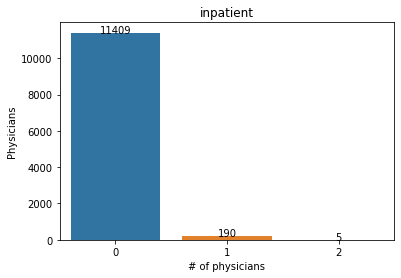

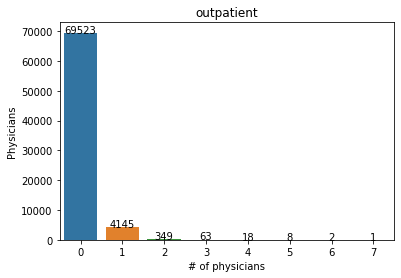

In [30]:
# doctors serve for diff providers
provider_per_doc_inpt = pd.DataFrame(inpt.groupby('AttendingPhysician').Provider.nunique().value_counts()).rename_axis('provider_num').reset_index().rename({'Provider': 'Physicians'},axis =1)
provider_per_doc_outpt = pd.DataFrame(outpt.groupby('AttendingPhysician').Provider.nunique().value_counts()).rename_axis('provider_num').reset_index().rename({'Provider': 'Physicians'},axis =1)

display('inpateint', provider_per_doc_inpt)
display('outpatient', provider_per_doc_outpt)

g = sns.barplot(x = provider_per_doc_inpt.index, y = "Physicians", data = provider_per_doc_inpt)
g.set(xlabel = "# of physicians")
g.set_title('inpatient')
for index, row in provider_per_doc_inpt.iterrows():
    g.text(row.name,row.Physicians, row.Physicians, color='black', ha="center")
plt.show()

k = sns.barplot(x = provider_per_doc_outpt.index, y = "Physicians", data = provider_per_doc_outpt)
for index, row in provider_per_doc_outpt.iterrows():
    k.text(row.name,row.Physicians, row.Physicians, color='black', ha="center")
k.set(xlabel = "# of physicians")
k.set_title('outpatient')
plt.show()

# check out the 5 physicians that work for 3 clinics 

In [63]:
# patients go to diff hospitals
inpt.groupby('BeneID').Provider.nunique().value_counts()

1    26694
2     3965
3      541
4       76
5       13
Name: Provider, dtype: int64

In [ ]:
inpt.groupby('AttendingPhysician').Provider.nunique().bar()
plt.xlabel('# of providers')
plt.ylabel('# of physicians')
plt.show()
# outpt.groupby('AttendingPhysician').Provider.nunique().hist(bins = 7)
# plt.xlabel('# of providers')
# plt.ylabel('# of physicians')
# plt.show()

,Provider
1,11409
2,190
3,5


In [34]:
inpt.groupby(['BeneID']).Provider.nunique().value_counts()

1    26694
2     3965
3      541
4       76
5       13
Name: Provider, dtype: int64

In [35]:
outpt.groupby(['BeneID']).Provider.nunique().value_counts()

1     49671
2     34432
3     21370
4     12646
5      7168
6      3992
7      2277
8      1192
9       610
10      288
11      177
12       89
13       39
14       12
15       11
16        4
17        1
19        1
Name: Provider, dtype: int64

In [92]:
bene[bene.columns[bene.columns.str.contains(pat = 'ChronicCond')]] = bene[bene.columns[bene.columns.str.contains(pat = 'ChronicCond')]].apply(lambda x: x - 1)

In [93]:
bene.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,0,1,0,1,1,0,0,0,1,0,0,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,1,1,1,1,1,1,1,1,1,1,1,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,0,1,1,1,1,1,1,0,1,1,1,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,0,0,1,1,1,1,0,0,0,0,1,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,1,1,1,1,0,1,0,1,1,1,1,0,0,1790,1200


In [94]:
inpt_bene = inpt.merge(bene, on = 'BeneID')

In [46]:
26000/138000

0.18840579710144928

In [107]:
inpt_bene_cond = inpt_bene[inpt_bene.columns[inpt_bene.columns.str.contains(pat = 'ChronicCond')]].sum(axis=1).value_counts()
inpt_bene_cond_counts = pd.DataFrame(inpt_bene_cond).reset_index().rename(columns = {'index':'chronic_cond_num', 0:'patient_num'}).sort_values(by = 'chronic_cond_num')
inpt_bene_cond_counts['ip_percent'] = inpt_bene_cond_counts.patient_num / inpt.BeneID.nunique()
inpt_bene_cond_counts

,chronic_cond_num,patient_num,ip_percent
11,0,131,0.004187
9,1,689,0.022021
6,2,2475,0.079101
4,3,4585,0.146537
1,4,6421,0.205216
0,5,7085,0.226437
2,6,6292,0.201093
3,7,5177,0.165458
5,8,3820,0.122088
7,9,2377,0.075969


In [96]:
outpt_bene = outpt.merge(bene, on = 'BeneID')

In [108]:
outpt_bene_cond = outpt_bene[outpt_bene.columns[outpt_bene.columns.str.contains(pat = 'ChronicCond')]].sum(axis=1).value_counts()
outpt_bene_cond_counts = pd.DataFrame(outpt_bene_cond).reset_index().rename(columns = {'index':'chronic_cond_num', 0:'patient_num'}).sort_values(by = 'chronic_cond_num')
outpt_bene_cond_counts['ip_percent'] = outpt_bene_cond_counts.patient_num / outpt.BeneID.nunique()
outpt_bene_cond_counts
# change 1 & 2 to 0 & 1

,chronic_cond_num,patient_num,ip_percent
11,0,331,0.002471
10,1,3501,0.026131
9,2,14747,0.110069
7,3,33302,0.248559
5,4,53754,0.401209
2,5,69431,0.518219
1,6,76406,0.570279
0,7,78284,0.584296
3,8,68542,0.511584
4,9,57638,0.430199


In [109]:
bene_cond_counts = inpt_bene_cond_counts.merge(outpt_bene_cond_counts, on = 'chronic_cond_num', suffixes=('_ip', '_op'))
bene_cond_counts

,chronic_cond_num,patient_num_ip,ip_percent_ip,patient_num_op,ip_percent_op
0,0,131,0.004187,331,0.002471
1,1,689,0.022021,3501,0.026131
2,2,2475,0.079101,14747,0.110069
3,3,4585,0.146537,33302,0.248559
4,4,6421,0.205216,53754,0.401209
5,5,7085,0.226437,69431,0.518219
6,6,6292,0.201093,76406,0.570279
7,7,5177,0.165458,78284,0.584296
8,8,3820,0.122088,68542,0.511584
9,9,2377,0.075969,57638,0.430199


In [106]:
test = bene_cond_counts.melt(id_vars = ['chronic_cond_num'], value_vars=['patient_num_ip', 'patient_num_op'])
test
# divide by totoal number of bene

,chronic_cond_num,variable,value
0,0,patient_num_ip,131
1,1,patient_num_ip,689
2,2,patient_num_ip,2475
3,3,patient_num_ip,4585
4,4,patient_num_ip,6421
5,5,patient_num_ip,7085
6,6,patient_num_ip,6292
7,7,patient_num_ip,5177
8,8,patient_num_ip,3820
9,9,patient_num_ip,2377


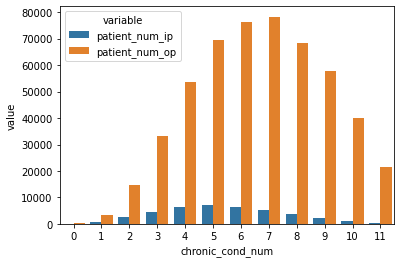

In [100]:
sns.barplot(x = 'chronic_cond_num', y = 'value', hue = 'variable', data = test, )

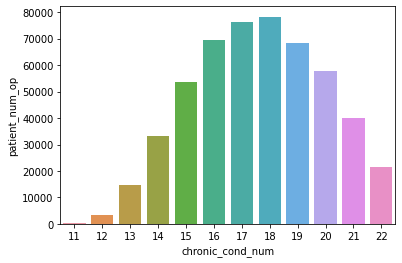

In [72]:
sns.barplot(x = 'chronic_cond_num', y = 'patient_num_op', data = bene_cond_counts)

In [ ]:
# for each provider, percentage of money coming from insurance vs patient


In [111]:
inpt.groupby('Provider').count().ClaimID.describe()

count    2092.000000
mean       19.347036
std        34.983155
min         1.000000
25%         3.000000
50%         8.000000
75%        19.000000
max       516.000000
Name: ClaimID, dtype: float64